Используйте готовый ноутбук с кластеризацией базы покупок интернет-магазина.
1. Удалите из выборки все строки про доставку.

2. Выведите две гистограммы:
 - распределения размеров классов - сколько корзин,
 - распределение количества уникальных позиций в классе.
3. Напишите продвинутую функцию визуализации одного выбранного класса:
 - размер класса,
 - количество уникальных позиций,
 - позиции, которые есть минимум в 20% корзин,
 - уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания моно-брендовых и моно-товарных закупок.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from sklearn.cluster import KMeans
import re
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('drive/MyDrive/Нейросети/online_carts.csv')
df

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
99627,NaN,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,NaN
99628,NaN,Крем-бальзам-архитектор волос для восстановле...,345,1,NaN
99629,NaN,Услуга доставки DPD до двери,350,1,NaN
99630,NaN,Шампунь разглаживающий с глиоксиловой кислот...,304,1,NaN


In [4]:
column = df.drop(['Unnamed: 0'], axis =1)
column.insert(0, column='Дата', value = [x for x in range(len(column))]) # Вставим новую колонку "Дата", чтобы из базы вытащить временные данные в отдельную колонку
column = column.fillna('unknown')                                        # Все Nan заполним строкой "unknown", чтобы не выскакивало ошибок

In [5]:
# Здесь будут лежать все индексы строк, где есть информация в формате даты
index_list = list(column[column['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index)

indx=0
for i in range(len(column)):
  if i in index_list:                            # Если индекс находится среди тех, где есть формат даты
    indx = i                                    # Обновляем текущий индекс
  column['Дата'][i] = column['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату


<ipython-input-5-dd2b95a23e8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column['Дата'][i] = column['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату


In [6]:
column = column.drop(column[column['Дата'].str.contains('Период')].index,axis = 0)
column = column.drop(column[column['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Удалим пустые строки между корзинами
column = column.drop(column[column['Валовая прибыль']==column['Дата']].index)                   # Удалим строки-даты, которые находятся в столбце корзин
column.reset_index(inplace=True)                                                    # Обновим индекс
column = column.drop('index',axis=1)

In [7]:
column.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown


In [8]:
column[column['Валовая прибыль'].str.contains("доставка")]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4


In [9]:
column = column.drop(column[column['Валовая прибыль'].str.contains('доставка')].index, axis=0)
column.reset_index(inplace=True)  # Обновим индекс
column = column.drop('index',axis=1)

In [10]:
column[column['Валовая прибыль'].str.contains("доставка")]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
8,01.01.2019 0:00:00,Услуга доставки DPD до двери,990,1,unknown
9,01.01.2019 0:00:00,Услуга доставки СДЭК,990,1,unknown
14,01.01.2019 0:00:00,Услуга доставки Почта России,300,1,unknown
102,01.02.2019 0:00:00,Услуга доставки DPD до двери,1340,2,unknown
103,01.02.2019 0:00:00,Услуга доставки Почта России,1200,6,unknown
...,...,...,...,...,...
99118,30.08.2019 0:00:00,Услуга доставки СДЭК,350,1,unknown
99131,30.08.2019 0:00:00,Услуга доставки DPD самовывоз,300,1,unknown
99143,30.08.2019 0:00:00,Услуга доставки СДЭК,300,1,unknown
99150,30.08.2019 0:00:00,Услуга доставки Почта России,300,1,unknown


In [11]:
# Удалим лишние пробелы и символы
for i,prod in enumerate(column['Валовая прибыль']):
  prod=re.sub(r"[\[\](),.«»\"\']"," ",prod) # Удалим лишние скобки, запятые, точки
  prod=prod.strip()                         # Удаляем пробелы в начале и в конце строки
  prod=prod.lower()                         # Приводим к нижнему регистру
  prod=re.sub("\s+"," ",prod)               # Удалим лишние пробелы
  prod=re.sub("(\d)\s*ml","\g<1>мл",prod)   # Заменим латиницу
  prod=re.sub("(\d)\s*l","\g<1>л",prod)
  prod=re.sub("(\d)\s*g","\g<1>g",prod)
  prod=re.sub("(\d)\s*sm","\g<1>см",prod)

  prod=re.sub("(\S)\s*-\s*(\S)","\g<1>-\g<2>",prod)       # Улучшим дефисы
  prod=re.sub("(\d+) (мл|г|см|м|л|мг)","\g<1>\g<2>",prod) # Подвинем единицы измерения

  column['Валовая прибыль'][i]=prod


In [12]:
column[200:230]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
200,01.02.2019 0:00:00,услуга доставки сдэк,350,2,unknown
201,01.02.2019 0:00:00,mcosm8020,19886,34,unknown
202,01.02.2019 0:00:00,6/7 темный блонд коричневый,689,1,unknown
203,01.02.2019 0:00:00,classic кусачки маникюрные для кожи ксс-4/6 6мм,337,1,unknown
204,01.02.2019 0:00:00,kapous обесцвечивающая пудра с антижелтым эффе...,467,1,unknown
205,01.02.2019 0:00:00,londa насос-дозатор для шампуней londa profess...,216,1,unknown
206,01.02.2019 0:00:00,midollo-шампунь с вытяжкой из бамбука для хим ...,1078,2,unknown
207,01.02.2019 0:00:00,ollin service line шампунь для придания холодн...,359,1,unknown
208,01.02.2019 0:00:00,ollin vision black черный крем-краска для бров...,235,1,unknown
209,01.02.2019 0:00:00,semi de line-бальзам семя льна питательный 1000мл,1437,3,unknown


In [13]:
MCOSM_list = list(column[column['Валовая прибыль'].str.contains("MCOSM".lower())].index)

CAFRE_list = list(column[column['Валовая прибыль'].str.contains("CAFRE".lower())].index)

In [14]:
total_list = sorted(MCOSM_list+CAFRE_list)
print(total_list)

MCOSM_list=total_list

[0, 10, 115, 151, 153, 157, 163, 172, 178, 182, 187, 193, 199, 201, 225, 234, 241, 245, 257, 260, 265, 272, 280, 292, 296, 298, 304, 314, 325, 346, 354, 357, 363, 369, 377, 381, 383, 388, 397, 400, 404, 407, 412, 416, 419, 426, 432, 434, 441, 452, 459, 465, 468, 480, 486, 488, 491, 496, 501, 504, 531, 539, 542, 545, 551, 555, 565, 571, 577, 579, 581, 588, 593, 599, 605, 610, 615, 624, 628, 636, 641, 643, 646, 650, 652, 657, 660, 667, 672, 677, 680, 684, 794, 802, 808, 810, 819, 822, 836, 849, 882, 885, 897, 902, 946, 952, 959, 1007, 1014, 1026, 1030, 1036, 1046, 1051, 1061, 1067, 1075, 1081, 1087, 1091, 1099, 1103, 1106, 1115, 1122, 1127, 1132, 1135, 1153, 1158, 1160, 1165, 1173, 1187, 1191, 1199, 1203, 1209, 1211, 1217, 1219, 1224, 1227, 1231, 1235, 1239, 1244, 1247, 1254, 1261, 1274, 1278, 1289, 1304, 1309, 1311, 1314, 1319, 1325, 1327, 1331, 1333, 1339, 1342, 1344, 1350, 1353, 1356, 1359, 1366, 1370, 1376, 1384, 1393, 1400, 1403, 1405, 1407, 1409, 1413, 1422, 1426, 1428, 1431, 1434,

In [15]:
all_carts = []
our_cart=[]
i=0                            # Счетчик для прохождения по базе
column2 = column['Валовая прибыль']
products = []

while i!=len(column):             # Пока не дойдем до конца списка
  if i in MCOSM_list:           # Если счетчик в списке индексов-корзин
    if i!=MCOSM_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = MCOSM_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины

      # Если корзина пустая (после удаления услуг)
      if (i==MCOSM_list[ind+1]-1):
        i+=1

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика (увеличиваем значение переменной)
      while i<MCOSM_list[ind+1]-1:
        our_cart.append(column2[i+1])
        products.append(column2[i+1])
        i+=1

    else: # Если же текущий индекс-флаг последний в списке, пробегаемся дальше по счетчику
          # До момента, когда он не будет равен концу списка всех строк в столбце-1
          # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      while i<(len(column)-1):
        our_cart.append(column2[i+1])
        products.append(column2[i+1])
        i+=1

    all_carts.append(our_cart)         # Закидываем корзину в список всех корзин
    our_cart=[]                    # Очищаем корзину

  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем

In [16]:
# Проверим, есть ли пустые корзины
for i,our_cart in enumerate(all_carts):
  if (len(our_cart)==0):
    print(i,end=" ")

In [17]:
# Удалим пустые корзины
delete_all_carts = []
for i,our_cart in enumerate(all_carts):
  if (len(our_cart)>0):
    delete_all_carts.append(our_cart)

all_carts=delete_all_carts

In [18]:
# Количество корзин
len(all_carts)

13641

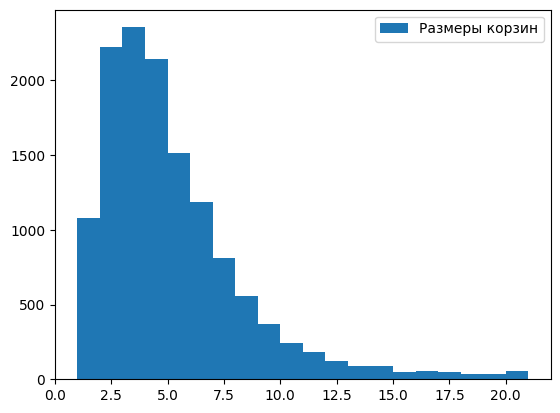

In [19]:
plt.hist([len(c) for c in all_carts], 20, [1, 21],label="Размеры корзин")
plt.legend()
plt.show()

In [20]:
labelEncoder = LabelEncoder()
labelEncoder.fit(products) # Обрабатываем все имеющиеся товары
maxproducts = max(labelEncoder.transform(products))+1 # Посчитаем количество уникальных товаров
all_cartsIndexes = [labelEncoder.transform(c) for c in all_carts]       # Создаем список индексов для каждой корзины

In [21]:
# Количество уникальных товаров
maxproducts

6588

In [22]:
num = 3                  # Укажем номер корзины
print(all_carts[num])        # Отобразим содержимое этой корзины
print(all_cartsIndexes[num]) # Отобразим соответствующие индексы

['услуга доставки сдэк']
[6094]


In [23]:
'''
  Функция преобразования вектора по приницпу bag of words
    Входные параметры:
      - trainVector - исходный вектор индексов слов
      - wordsCount - установленная длина вектора
    Функция возращает:
      - сформированный вектор из 0 и 1
'''
def transformations_Vector(trainVector, wordsCount):
  out = np.zeros(wordsCount)                   # Создаем вектор из нулей длиной wordsCount
  for x in trainVector:                        # Пробегаем по всем индексам в trainVector
    out[x] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса
  return out                                   # Возвращаем сформированный вектор


'''
  Функция преобразования выборки (обучающей или проверочной) по принципу Bag of words
    Входные параметры:
      - trainSet - выборка
      - wordsCount - установленная длина вектора
    Функция возращает:
      - сформированная выборка из 0 и 1
'''
def transformations_Set(trainSet, wordsCount):
  out = []
  for x in trainSet:                           # Пробегаем по всем элемента выборки
    out.append(transformations_Vector(x, wordsCount))     # Получаем вектор Bag of words для текущего элемента
  return np.array(out)                         # Возвращаем сформированную выборку

In [24]:
all_carts01 = transformations_Set(all_cartsIndexes, maxproducts) # Создаем выборку по принципу bag of words

In [25]:
num = 3                  # Указываем номер корзины
print(all_carts[num])
print(all_cartsIndexes[num]) # Выводим список соответствующих индексов
print(all_carts01[num])      # Выводим соответсвующий список bag of words

['услуга доставки сдэк']
[6094]
[0. 0. 0. ... 0. 0. 0.]


## Кластеризация

In [26]:
cur_time = time.time()
clustersCount = 100
kmean = KMeans(clustersCount)
kmean.fit(all_carts01)            # Производим кластеризацию набора all_carts01
labels = kmean.labels_        # Сохраняем метки в переменную labels
npall_carts = np.array(all_carts)     # Преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time,2),'c')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Время обработки:  468.91 c


<ipython-input-26-3a28234a4a73>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  npall_carts = np.array(all_carts)     # Преобразуем список корзин в numpy


In [27]:
print(all_carts[0])
print(len(all_carts))
print(len(npall_carts))

['contura hs61машинка для стрижки волос', 'holika holika универсальный гель 99% алоэ вера 250мл', 'kapous бальзам-уход для придания объема volume up 350мл', 'kapous шампунь для придания объема volume up 350мл', 'xpert hs71машинка для стрижки волос', 'лп тна саваж панаш 250мл', 'перчатки 50 пар винил размер s черные', 'услуга доставки dpd до двери', 'услуга доставки сдэк']
13641
13641


In [28]:
def Cluster(x):
  clasterSize = x.shape[0]
  sumX = np.sum(x, axis=0)
  sumX /= clasterSize                                # Смотрим, насколько часто конкретный товар появляется в данном кластере

  products2 = []
  productsValues = []

  for i in range(sumX.shape[0]):
    if (sumX[i] > 0):                                # Если товар присутствует в данном кластере
      product = labelEncoder.inverse_transform([i]) # Получаем обратный энкодер
      products2.append(product)                     # Добавляем товар в список товаров
      productsValues.append(sumX[i])                 # В список значений добавляем количество данного товара в текущем кластере

  return products2, productsValues

In [29]:
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

In [30]:
print(len(clusterSize))
clusterSize[:10]

100


[4, 30, 299, 3611, 1, 1, 38, 1, 1, 106]

In [31]:
for Our_classes in range(len(clusterSize)):
  if (clusterSize[Our_classes] > 5):                       # Если размер кластера больше 5
    prod, prodVal = Cluster(all_carts01[labels==Our_classes]) # Получаем список товаров и их количество в текущем кластере
    print("Покупок:", clusterSize[Our_classes])            # Выводим размер текущего кластера
    print("Товаров:", len(prod))                              # Выводим общее число товаров в текущем кластере
    prod = np.array(prod)
    prodVal = np.array(prodVal)
    indexes = prodVal > 0.6                                   # Берем индексы тех товаров, доля которых составляет больше 20%
    indexedProd = prod[indexes]                                # Выбираем эти товары из prod
    indexedProdVal = prodVal[indexes]                          # Выбираем доли этих товаров

    # Отображаем долю товаров и названия самих товаров
    for i in range(len(indexedProd)):
      print(round(100*indexedProdVal[i]), "% ", indexedProd[i], sep="")

    print()
    print()

Покупок: 30
Товаров: 201
67% ['бальзам-сияние для всех типов волос 250мл']
100% ['блеск-шампунь для всех типов волос 300мл']


Покупок: 299
Товаров: 681
77% ['бальзам для интенсивного увлажнения волос otium aqua 1000мл']
97% ['шампунь для интенсивного увлажнения волос otium aqua 1000мл']


Покупок: 3611
Товаров: 3262
100% ['услуга доставки сдэк']


Покупок: 38
Товаров: 171
95% ['кератиновая маска для волос estel keratin 250мл']


Покупок: 106
Товаров: 559
96% ['бальзам для ежедневного применения 1000мл curex classic']
100% ['маска питательная для всех типов волос 500мл curex classic']
95% ['шампунь для ежедневного применения 1000мл curex classic']


Покупок: 289
Товаров: 871
72% ['бальзам для ежедневного применения 1000мл curex classic']
98% ['шампунь для ежедневного применения 1000мл curex classic']


Покупок: 78
Товаров: 567


Покупок: 74
Товаров: 260
100% ['скраб с морской солью регенерирующий likato 250мл']


Покупок: 265
Товаров: 594
100% ['услуга доставки dpd самовывоз']


Покупо

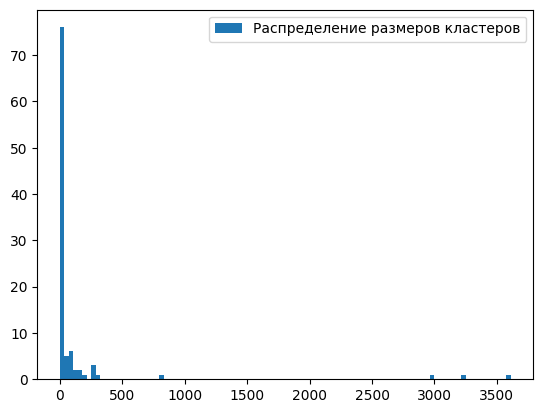

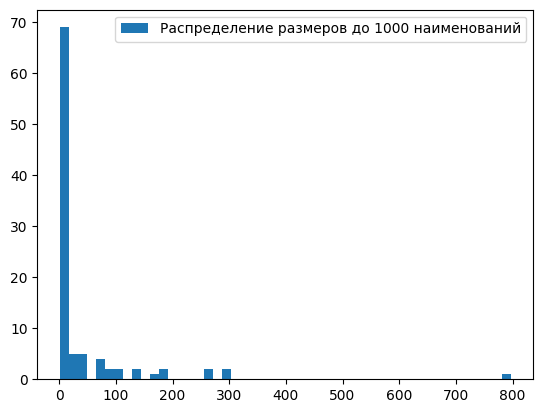

In [32]:
plt.hist(clusterSize, 100, label="Распределение размеров кластеров")
plt.legend()
plt.show()

npClusterSize=np.array(clusterSize)
plt.hist(npClusterSize[npClusterSize<1000], 50, label="Распределение размеров до 1000 наименований")
plt.legend()
plt.show()


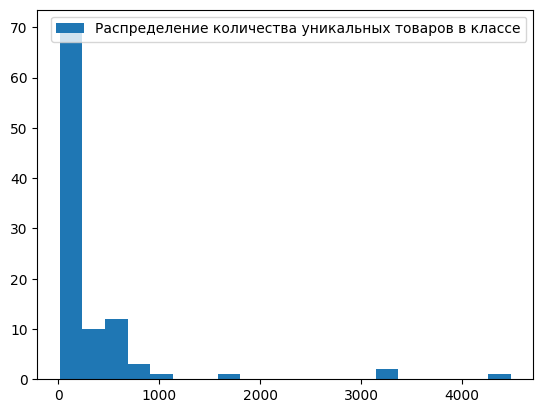

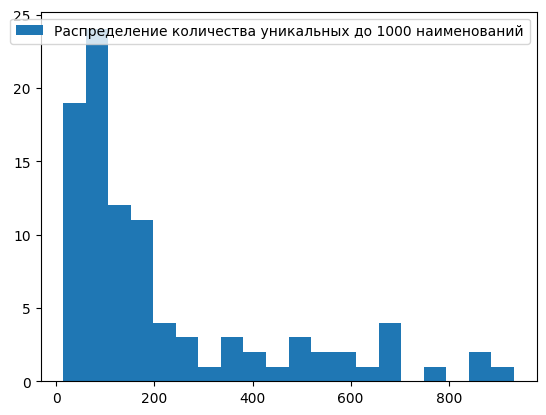

In [33]:
numProdVal=[]
for Our_classes in range(clustersCount):
  prod, prodVal = Cluster(all_carts01[labels==Our_classes]) # Получаем список товаров и их количество в текущем кластере
  unique=np.unique(prod) # Получаем только список уникальных товаров в классе
  numProdVal.append(len(unique))

plt.hist(numProdVal, 20, label="Распределение количества уникальных товаров в классе")
plt.legend()
plt.show()

npNumProdVal=np.array(numProdVal)
plt.hist(npNumProdVal[npNumProdVal<1000], 20, label="Распределение количества уникальных до 1000 наименований")
plt.legend()
plt.show()

# Функция визуализации

In [34]:
print(products)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
for Our_classes in range(len(clusterSize)): # Пробегаем по всем кластерам
  if (clusterSize[Our_classes] > 5):        # Если размер кластера больше 5
    print("Класс ",Our_classes,"-"*20)
    print("Размер класса:", clusterSize[Our_classes])

    # Получим количество уникальных товаров
    prod, prodVal = Cluster(all_carts01[labels == Our_classes])
    unique = len(np.unique(prod))
    print("Количество уникальных товаров:",unique)

    print()

    # Получим список товаров, которые есть минимум в 20% корзин
    print("Товары, которые есть минимум в 20% корзин:")
    prod = np.array(prod)
    prodVal = np.array(prodVal)

    # Индексы товаров
    indexes = prodVal >= 0.2
    indexedProd = prod[indexes]
    indexedProdVal = prodVal[indexes]

    # Отсортируем товары по количеству вхождений
    products=[]
    for i in range(len(indexedProd)):
      products.append([indexedProdVal[i],indexedProd[i]])
    products = sorted(products, reverse=1)

    # Выведем товары
    for p in products:
      print(round(100*p[0]), "% ", p[1][0], sep="")

    print()

    # Получим список уникальных слов, которые есть минимум в 20% корзин
    print("Уникальные слова в описании товаров:")

    all_words=[]
    for p in prod:
      all_words+=p[0].split(" ")
    unique_words=np.unique(all_words)

    unique_words2=[]
    for w in unique_words:
      word=0
      for p in prod:
        if (w in p[0]):
          word+=1
      unique_words2.append(word/len(prod))

    unique_words=np.array(unique_words)
    unique_words2=np.array(unique_words2)

    indexes = unique_words2 >= 0.2
    index_words = unique_words[indexes]
    index_words2 = unique_words2[indexes]

    sorted_list=[]
    for i in range(len(index_words)):
      sorted_list.append([index_words2[i],index_words[i]])
    sorted_list=sorted(sorted_list,reverse=1)

    for w in sorted_list:
      print(round(100*w[0]), "% ", w[1], sep="")

    print()
    print()

Класс  1 --------------------
Размер класса: 30
Количество уникальных товаров: 201

Товары, которые есть минимум в 20% корзин:
100% блеск-шампунь для всех типов волос 300мл
67% бальзам-сияние для всех типов волос 250мл
23% шампунь для ежедневного применения 1000мл curex classic
20% интенсивная маска для поврежденных волос 500мл

Уникальные слова в описании товаров:
95% м
90% с
85% и
85% 0
84% в
69% для
53% волос
41% 1
31% 5
30% х
28% 2
26% 50
23% шампунь
21% estel


Класс  2 --------------------
Размер класса: 299
Количество уникальных товаров: 681

Товары, которые есть минимум в 20% корзин:
97% шампунь для интенсивного увлажнения волос otium aqua 1000мл
77% бальзам для интенсивного увлажнения волос otium aqua 1000мл
23% комфорт-маска для интенсивного увлажнения волос otium aqua 300мл

Уникальные слова в описании товаров:
84% с
83% и
77% р
75% 0
74% в
72% к
71% т
52% п
50% a
49% для
44% s
43% 00
41% 1
34% 5
30% c
29% волос
28% d
27% 2
26% m
26% p
25% 10
23% 50
20% 100


Класс  3 ------